In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [3]:
# Nombres de columnas
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty'
]


In [4]:
# Cargar datos
df_train = pd.read_csv('../data/raw/KDDTrain+.txt', names=column_names, header=None)
df_test = pd.read_csv('../data/raw/KDDTest+.txt', names=column_names, header=None)

print("✓ Datos cargados")

✓ Datos cargados


In [5]:
# Mapeo de ataques a categorías
attack_mapping = {
    'normal': 'Normal',
    'neptune': 'DoS', 'smurf': 'DoS', 'pod': 'DoS', 'teardrop': 'DoS',
    'back': 'DoS', 'land': 'DoS',
    'portsweep': 'Probe', 'ipsweep': 'Probe', 'satan': 'Probe', 'nmap': 'Probe',
    'warezclient': 'R2L', 'guess_passwd': 'R2L', 'ftp_write': 'R2L',
    'imap': 'R2L', 'spy': 'R2L', 'multihop': 'R2L', 'warezmaster': 'R2L',
    'phf': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'rootkit': 'U2R', 'perl': 'U2R'
}

df_train['attack_category'] = df_train['label'].map(attack_mapping)
df_test['attack_category'] = df_test['label'].map(attack_mapping)

print("✓ Categorías creadas")
print(df_train['attack_category'].value_counts())

✓ Categorías creadas
attack_category
Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64


In [6]:
# Verificar valores nulos
print("Valores nulos por columna:")
nulls = df_train.isnull().sum()
if nulls.sum() == 0:
    print("✓ No hay valores nulos en el dataset")
else:
    print(nulls[nulls > 0])

Valores nulos por columna:
✓ No hay valores nulos en el dataset


In [7]:
# Separar variables numéricas y categóricas
numeric_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_train.select_dtypes(include=['object']).columns.tolist()

# Remover las columnas target
numeric_features.remove('difficulty')
categorical_features.remove('label')
categorical_features.remove('attack_category')

print(f"📊 Features numéricas: {len(numeric_features)}")
print(f"📊 Features categóricas: {len(categorical_features)}")
print(f"\nCategóricas: {categorical_features}")

📊 Features numéricas: 38
📊 Features categóricas: 3

Categóricas: ['protocol_type', 'service', 'flag']


In [8]:
# Estadísticas básicas
print("ESTADÍSTICAS DESCRIPTIVAS - Variables Numéricas Clave:")
print("="*60)
key_features = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count']
print(df_train[key_features].describe())

ESTADÍSTICAS DESCRIPTIVAS - Variables Numéricas Clave:
           duration     src_bytes     dst_bytes          count      srv_count
count  125973.00000  1.259730e+05  1.259730e+05  125973.000000  125973.000000
mean      287.14465  4.556674e+04  1.977911e+04      84.107555      27.737888
std      2604.51531  5.870331e+06  4.021269e+06     114.508607      72.635840
min         0.00000  0.000000e+00  0.000000e+00       0.000000       0.000000
25%         0.00000  0.000000e+00  0.000000e+00       2.000000       2.000000
50%         0.00000  4.400000e+01  0.000000e+00      14.000000       8.000000
75%         0.00000  2.760000e+02  5.160000e+02     143.000000      18.000000
max     42908.00000  1.379964e+09  1.309937e+09     511.000000     511.000000


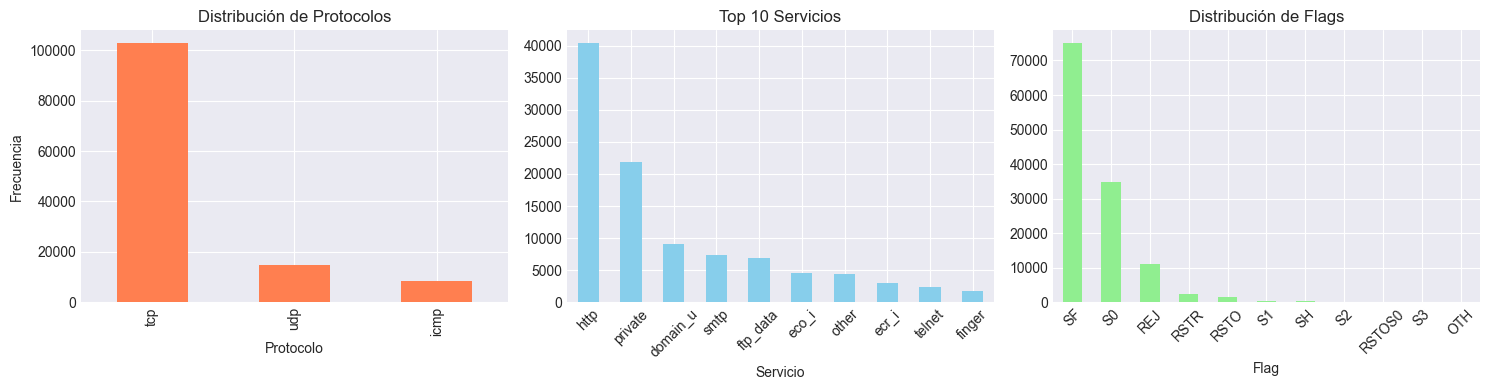

In [9]:
# Análisis de variables categóricas
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Protocol Type
df_train['protocol_type'].value_counts().plot(kind='bar', ax=axes[0], color='coral')
axes[0].set_title('Distribución de Protocolos')
axes[0].set_xlabel('Protocolo')
axes[0].set_ylabel('Frecuencia')

# Service
df_train['service'].value_counts().head(10).plot(kind='bar', ax=axes[1], color='skyblue')
axes[1].set_title('Top 10 Servicios')
axes[1].set_xlabel('Servicio')
axes[1].tick_params(axis='x', rotation=45)

# Flag
df_train['flag'].value_counts().plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Distribución de Flags')
axes[2].set_xlabel('Flag')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Distribución Normal vs Ataques:
is_attack
0    67343
1    58630
Name: count, dtype: int64

Porcentaje de ataques: 46.54%


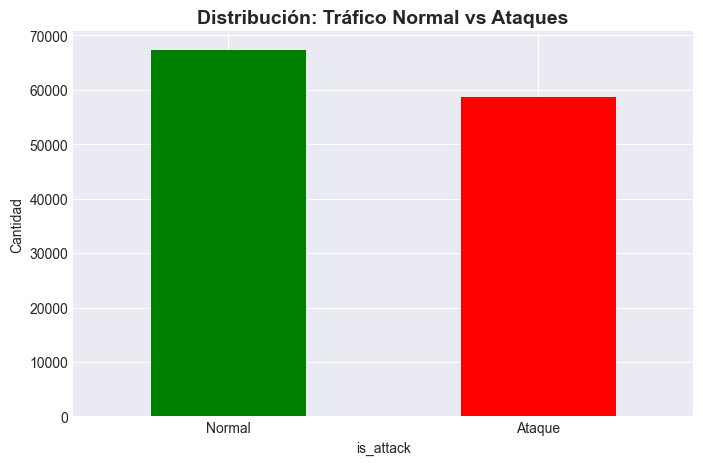

In [10]:
# Crear variable binaria (Normal = 0, Ataque = 1)
df_train['is_attack'] = (df_train['attack_category'] != 'Normal').astype(int)

print("Distribución Normal vs Ataques:")
print(df_train['is_attack'].value_counts())
print(f"\nPorcentaje de ataques: {df_train['is_attack'].mean()*100:.2f}%")

# Visualización
plt.figure(figsize=(8, 5))
df_train['is_attack'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.xticks([0, 1], ['Normal', 'Ataque'], rotation=0)
plt.title('Distribución: Tráfico Normal vs Ataques', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad')
plt.show()

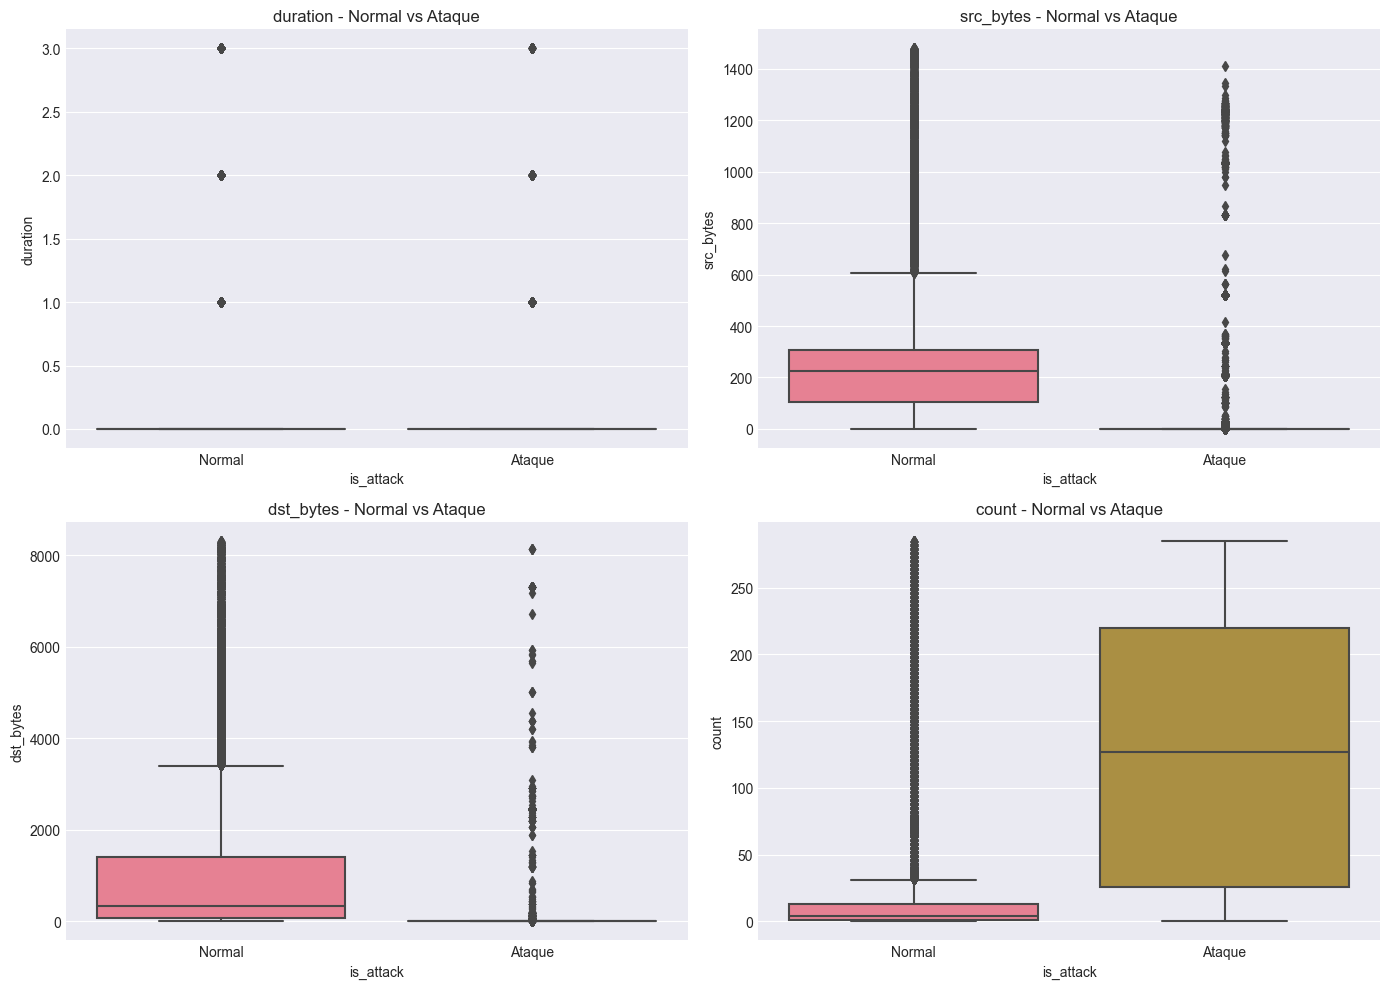

In [11]:
# Comparar algunas features clave entre Normal y Ataques
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features_to_compare = ['duration', 'src_bytes', 'dst_bytes', 'count']

for idx, feature in enumerate(features_to_compare):
    row = idx // 2
    col = idx % 2
    
    # Limitar outliers para mejor visualización
    df_plot = df_train[df_train[feature] < df_train[feature].quantile(0.95)]
    
    sns.boxplot(data=df_plot, x='is_attack', y=feature, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} - Normal vs Ataque')
    axes[row, col].set_xticklabels(['Normal', 'Ataque'])

plt.tight_layout()
plt.show()

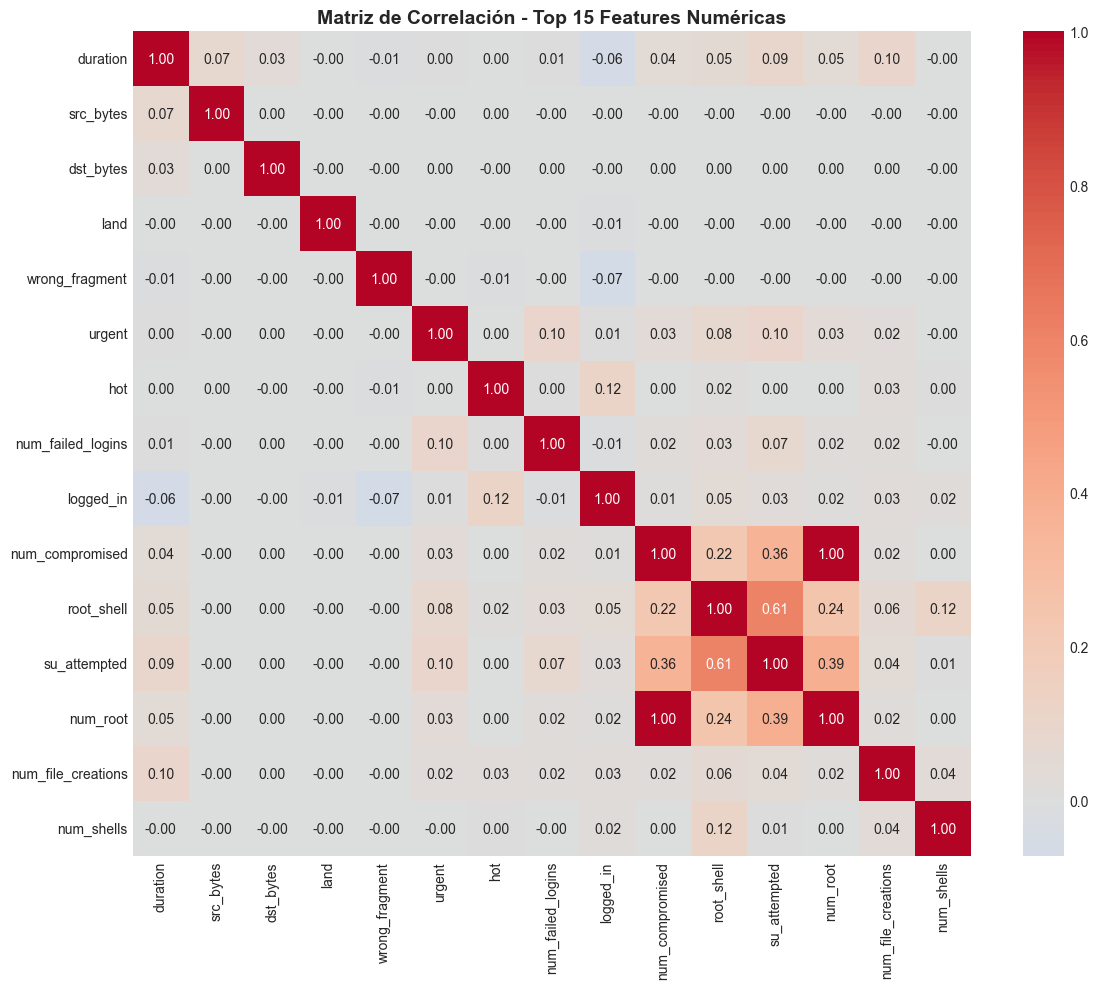

In [12]:
# Matriz de correlación (solo primeras 15 features numéricas para claridad)
plt.figure(figsize=(12, 10))
correlation_matrix = df_train[numeric_features[:15]].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Matriz de Correlación - Top 15 Features Numéricas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [13]:
print("="*70)
print("RESPUESTAS AL ANÁLISIS EXPLORATORIO")
print("="*70)

# 1. Protocolo más común
print("\n1️⃣ PROTOCOLO MÁS COMÚN:")
protocolo_top = df_train['protocol_type'].value_counts().idxmax()
porcentaje = (df_train['protocol_type'].value_counts().max() / len(df_train)) * 100
print(f"   ➤ {protocolo_top.upper()} con {porcentaje:.2f}% de las conexiones")

# 2. Diferencias Normal vs Ataque
print("\n2️⃣ DIFERENCIAS NORMAL VS ATAQUE:")
for feature in ['duration', 'src_bytes', 'count']:
    media_normal = df_train[df_train['is_attack']==0][feature].mean()
    media_ataque = df_train[df_train['is_attack']==1][feature].mean()
    diff = ((media_ataque - media_normal) / media_normal) * 100
    print(f"   {feature:12s}: Normal={media_normal:8.2f} | Ataque={media_ataque:8.2f} | Diff={diff:+6.1f}%")

# 3. Correlaciones altas
print("\n3️⃣ CORRELACIONES ALTAS (>0.8):")
correlation_matrix = df_train[numeric_features].corr()
high_corr_count = 0
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_count += 1
            print(f"   {correlation_matrix.columns[i]} ↔ {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}")

if high_corr_count == 0:
    print("   No se encontraron correlaciones >0.8")

RESPUESTAS AL ANÁLISIS EXPLORATORIO

1️⃣ PROTOCOLO MÁS COMÚN:
   ➤ TCP con 81.52% de las conexiones

2️⃣ DIFERENCIAS NORMAL VS ATAQUE:
   duration    : Normal=  168.59 | Ataque=  423.32 | Diff=+151.1%
   src_bytes   : Normal=13133.28 | Ataque=82820.14 | Diff=+530.6%
   count       : Normal=   22.52 | Ataque=  154.85 | Diff=+587.7%

3️⃣ CORRELACIONES ALTAS (>0.8):
   hot ↔ is_guest_login: 0.860
   num_compromised ↔ num_root: 0.999
   serror_rate ↔ srv_serror_rate: 0.993
   serror_rate ↔ dst_host_serror_rate: 0.979
   serror_rate ↔ dst_host_srv_serror_rate: 0.981
   srv_serror_rate ↔ dst_host_serror_rate: 0.978
   srv_serror_rate ↔ dst_host_srv_serror_rate: 0.986
   rerror_rate ↔ srv_rerror_rate: 0.989
   rerror_rate ↔ dst_host_rerror_rate: 0.927
   rerror_rate ↔ dst_host_srv_rerror_rate: 0.964
   srv_rerror_rate ↔ dst_host_rerror_rate: 0.918
   srv_rerror_rate ↔ dst_host_srv_rerror_rate: 0.970
   dst_host_srv_count ↔ dst_host_same_srv_rate: 0.897
   dst_host_serror_rate ↔ dst_host_srv_s